In [1]:
!pip install --upgrade pip
!pip install albumentations
!pip install --upgrade scikit-image

  Using cached https://files.pythonhosted.org/packages/54/0c/d01aa759fdc501a58f431eb594a17495f15b88da142ce14b5845662c13f3/pip-20.0.2-py2.py3-none-any.whl
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 116 kB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 631 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 28.2 MB 25.3 MB/s eta 0:00:01     |█████████████▉                  | 12.2 MB 25.3 MB/s eta 0:00:01
  Created wheel for albumentations: filename=albumentations-0.4.5-py3-none-any.whl size=63526 sha256=701af0f89095fc0139387a705c6f762d7731742df6da838c02889c83a8900f8a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/78/d2/b4/617573279167b9cb8fd3a2d17923ae044d5d213bb552abc1be
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654028 sha256=a8c3b06832fa23a7ad8bcc8db85d2bdc98d559ef8d6f56d4130a0487e49e7c45
  Stored in directory: /

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import efficientnet.keras as efn 

model = efn.EfficientNetB0(weights='imagenet')  # or weights='noisy-student'

Using TensorFlow backend.














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

21831680/21826536 [==============================] - 3s 0us/step


In [4]:
from efficientnet.keras import EfficientNetB0
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from data_loader import DataLoader
# from adam_lr_mult import Adam_lr_mult

In [5]:
"""
Adam optimizer with learning rate multipliers | Erik Brorson
https://erikbrorson.github.io/2018/04/30/Adam-with-learning-rate-multipliers/
"""
from keras.legacy import interfaces
import keras.backend as K
from keras.optimizers import Optimizer

class Adam_lr_mult(Optimizer):
    """Adam optimizer.
    Adam optimizer, with learning rate multipliers built on Keras implementation
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        
    AUTHOR: Erik Brorson
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False,
                 multipliers=None, debug_verbose=False,**kwargs):
        super(Adam_lr_mult, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.multipliers = multipliers
        self.debug_verbose = debug_verbose

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):

            # Learning rate multipliers
            if self.multipliers:
                multiplier = [mult for mult in self.multipliers if mult in p.name]
            else:
                multiplier = None
            if multiplier:
                new_lr_t = lr_t * self.multipliers[multiplier[0]]
                if self.debug_verbose:
                    print('Setting {} to learning rate {}'.format(multiplier[0], new_lr_t))
                    print(K.get_value(new_lr_t))
            else:
                new_lr_t = lr_t
                if self.debug_verbose:
                    print('No change in learning rate {}'.format(p.name))
                    print(K.get_value(new_lr_t))
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - new_lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - new_lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad,
                  'multipliers':self.multipliers}
        base_config = super(Adam_lr_mult, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [18]:
def prepare_new_model(input_shape, class_count):
    # 学習済みモデルの取り出し
    feature_extractor = EfficientNetB0(input_shape=input_shape, weights='imagenet', include_top=False)
    # 多クラス分類器を引っ付ける
    x = feature_extractor.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(rate=0.25)(x)
    x = Dense(class_count, activation='softmax')(x)
    # 新たなモデルの定義
    model = Model(inputs=feature_extractor.input, outputs=x)
    print(model.summary())
    return model

def get_adam_for_fine_tuning(lr, decay, multiplier, model):
    lr_multiplier = {}
    # 自分が引っ付けたレイヤーの学習係数は1、学習済みの部分は小さな値を設定する
    for layer in model.layers:
        if 'dense' in layer.name:
            lr_multiplier[layer.name] = 1.0
        else:
            lr_multiplier[layer.name] = multiplier
    return Adam_lr_mult(lr=lr, decay=decay, multipliers=lr_multiplier)

In [19]:
def train(epochs, batch_size, input_shape, class_count):
    # 学習用画像データローダー
    train_data_loader = DataLoader(
        'data/training/training', 
        batch_size, input_shape, 
        do_augmentation=True
    )
    train_generator = train_data_loader.get_data_loader()
    # 検証用画像データローダー
    val_data_loader = DataLoader(
        'data/validation/validation', 
        batch_size, input_shape, 
        do_augmentation=False
    )
    val_generator = val_data_loader.get_data_loader()
    # モデルの生成
    model = prepare_new_model(input_shape, class_count)
    # ファインチューニング用Adamオプティマイザ
    optimizer = get_adam_for_fine_tuning(lr=1e-3, decay=1e-5, multiplier=0.01, model=model)
    # コンパイルして
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # fit_generatorするだけ
    h = model.fit_generator(
        train_generator,
        train_data_loader.iterations,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_data_loader.iterations
    )
    return model, h
    # 学習データ、検証データのロスとAccをファイルに出力
    with open('loss.csv', 'a') as f:
        for loss_t, acc_t, loss_v, acc_v in zip(h.history['loss'], h.history['acc'], h.history['val_loss'], h.history['val_acc']):
            f.write(str(loss_t) + ',' + str(acc_t) + ',' + str(loss_v) + ',' + str(acc_v) + '\n')

In [20]:
epochs = 5
batch_size = 16
input_shape = (224, 224, 3)
class_count = 10
model, h = train(epochs, batch_size, input_shape, class_count)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

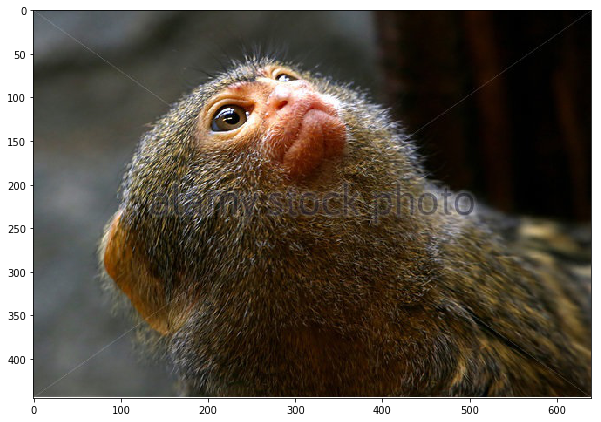

In [39]:
from skimage.io import imread
import matplotlib.pyplot as plt
# test image
image = imread('data/validation/validation/n4/n400.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [40]:
from efficientnet.keras import center_crop_and_resize, preprocess_input
import numpy as np

# preprocess input
image_size = model.input_shape[1]
x = center_crop_and_resize(image, image_size=image_size)
x = preprocess_input(x)
x = np.expand_dims(x, 0)

# make prediction and decode
y = model.predict(x)
# decode_predictions(y)

In [41]:
class_labels = [f"n{i}" for i in range(10)]

# 最大スコアのラベルを取得
pred = np.argmax(y, axis=-1)

# print the label of the class with maximum score
print(class_labels[pred[0]])

n4
